In [1]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("data.csv")

In [7]:
data

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target
0,0.113768,0.930064,0.330528,0.010987,0.265703,0.699462,0.058465,0.431643,0.650958,0.751820,30.147094
1,0.380048,0.485946,0.870232,0.473401,0.454516,0.500864,0.471723,0.234329,0.072982,0.008372,21.424402
2,0.768462,0.217706,0.727438,0.718377,0.452155,0.434638,0.043989,0.972489,0.450133,0.378157,31.422056
3,0.606637,0.604335,0.540332,0.491236,0.325632,0.206348,0.825767,0.332475,0.955518,0.162811,31.308588
4,0.119770,0.469718,0.632829,0.504207,0.238259,0.452457,0.775360,0.174262,0.117621,0.218883,23.322751
...,...,...,...,...,...,...,...,...,...,...,...
995,0.538751,0.072868,0.337400,0.531014,0.240128,0.652470,0.772777,0.062364,0.860766,0.594596,32.910569
996,0.898252,0.169217,0.750159,0.155727,0.844080,0.403090,0.098818,0.360846,0.613283,0.323710,27.457300
997,0.813122,0.251505,0.284456,0.314093,0.869697,0.995674,0.971214,0.324628,0.584621,0.020221,32.980881
998,0.722563,0.533463,0.747446,0.973052,0.462915,0.959898,0.561589,0.059606,0.599894,0.407610,34.254264


Имеем 1000 объектов и 10 признаков у каждого (+таргет)!

Обучим модель линейной регрессии:

$$
a(x) = \beta_1 d_{1} + \beta_2 d_{2} + \beta_3 d_{3} + \beta_4 d_{4} + \beta_5 d_{5} + \beta_6 d_{6} + \beta_7 d_{7} + \beta_8 d_{8} + \beta_9 d_{9} + \beta_{10} d_{10} + \beta_0
$$

Которая минимизирует MSE:

$$
Q(a(X), Y) = \sum_i^{1000} (a(x_i) - y_i)^2
$$

In [ ]:
X = data.drop(['target'], axis=1)

In [ ]:
Y = data['target']

In [19]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X, Y)

print(f"Коэффициенты модели: {model.coef_}, свободный вес: {np.round(model.intercept_, 2)}")

Коэффициенты модели: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], свободный вес: 4.37


In [93]:
class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии 
    """

    def __init__(self, samples: pd.DataFrame, targets: pd.DataFrame,
                 learning_rate: float = 1e-3, threshold = 1e-6, copy: bool = True):
        """
        self.samples - матрица признаков
        self.targets - вектор таргетов
        self.beta - вектор из изначальными весами модели == коэффициентами бета (состоит из единиц)
        self.learning_rate - параметр *learning_rate* для корректировки нормы градиента
        self.threshold - величина, меньше которой изменение в loss-функции означает остановку градиентного спуска
        iteration_loss_dict - словарь, который будет хранить номер итерации и соответствующую MSE
        copy: копирование матрицы признаков или создание изменения in-place
        """

        if copy:
            self.samples = samples.copy()
        else:
            self.samples = samples
        
        self.samples = samples
        self.targets = targets
        self.beta = np.ones(samples.shape[1])
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.iteration_loss_dict = {}
        
    def add_constant_feature(self):
        """
        Метод для создания константной фичи в матрице объектов samples
        Метод создает колонку с константным признаком (interсept) в матрице признаков.
        Hint: так как количество признаков увеличилось на одну, не забудьте дополнить вектор с изначальными весами модели!
        """
        self.samples = np.column_stack((self.samples, np.ones(self.samples.shape[0])))
        self.beta = np.append(self.beta, 1)
        
    def calculate_mse_loss(self) -> float:
        """
        Метод для расчета среднеквадратической ошибки
        
        :return: среднеквадратическая ошибка при текущих весах модели : float
        """

        return ((np.dot(self.samples, self.beta) - self.targets) ** 2).mean()

    def calculate_gradient(self) -> np.ndarray:
        """
        Метод для вычисления вектора-градиента
        Метод возвращает вектор-градиент, содержащий производные по каждому признаку.
        Сначала матрица признаков скалярно перемножается на вектор self.beta, и из каждой колонки
        полученной матрицы вычитается вектор таргетов. Затем полученная матрица скалярно умножается на матрицу признаков.
        Наконец, итоговая матрица умножается на 2 и усредняется по каждому признаку.
        
        :return: вектор-градиент, т.е. массив, содержащий соответствующее количество производных по каждой переменной : np.ndarray
        """
        # ravel <=> flatten - убирает все внутренние скобки и возвращает одномерный массив из элементов
        N = self.samples.shape[0]
        scalar_value = (np.dot(self.samples, self.beta.reshape(-1, 1)).ravel() - self.targets).values
        result = 2 / N * np.dot(scalar_value, self.samples)
        return result
    
    
    def iteration(self):
        """
        Обновляем веса модели в соответствии с текущим вектором-градиентом
        """
        self.beta = self.beta - self.learning_rate * self.calculate_gradient()
        
    def learn(self):
        """
        Итеративное обучение весов модели до срабатывания критерия останова
        Запись mse и номера итерации в iteration_loss_dict
        
        Описание алгоритма работы для изменения бет:
            Фиксируем текущие beta -> start_betas
            Делаем шаг градиентного спуска
            Записываем новые beta -> new_betas
            Пока |L(new_beta) - L(start_beta)| >= threshold:
                Повторяем первые 3 шага
                
        Описание алгоритма работы для изменения функции потерь:
            Фиксируем текущие mse -> previous_mse
            Делаем шаг градиентного спуска
            Записываем новые mse -> next_mse
            Пока |(previous_mse) - (next_mse)| >= threshold:
                Повторяем первые 3 шага
        """
        previous_mse = self.calculate_mse_loss()
        self.iteration()
        next_mse = self.calculate_mse_loss()
        iter_num = 0
        while abs(previous_mse - next_mse) > self.threshold:
            self.iteration_loss_dict[iter_num] = previous_mse
            previous_mse = next_mse
            self.iteration()
            next_mse = self.calculate_mse_loss()
            iter_num += 1

In [94]:
GD = GradientDescentMse(samples=X, targets=Y)
GD.add_constant_feature()
GD.learn()

In [95]:
GD.beta

array([0.88733305, 1.90100713, 2.88063607, 3.87662612, 4.89623507,
       5.89126182, 6.89254811, 7.90311947, 8.87580109, 9.86109585,
       4.94854733])

В машинном обучении зачастую исследуют так называемые **траектории обучения** (или **learning paths**). Это графики, показывающие, как во время обучения при каждой следующей итерации изменялось значение минимизируемого функционала. Постройте такие траектории для различных **learning rate**'ов и **threshold**'ов. Советуем использовать для этого разобранный на занятиях **add_subplot** метод. 

Возьмите следующие **threshold**'ы: 1e-2, 1e-3, 1e-4, 1e-5

И следующие значения **learning rate**'а: 1e-1, 5e-2, 1e-2, 5e-3, 1e-3

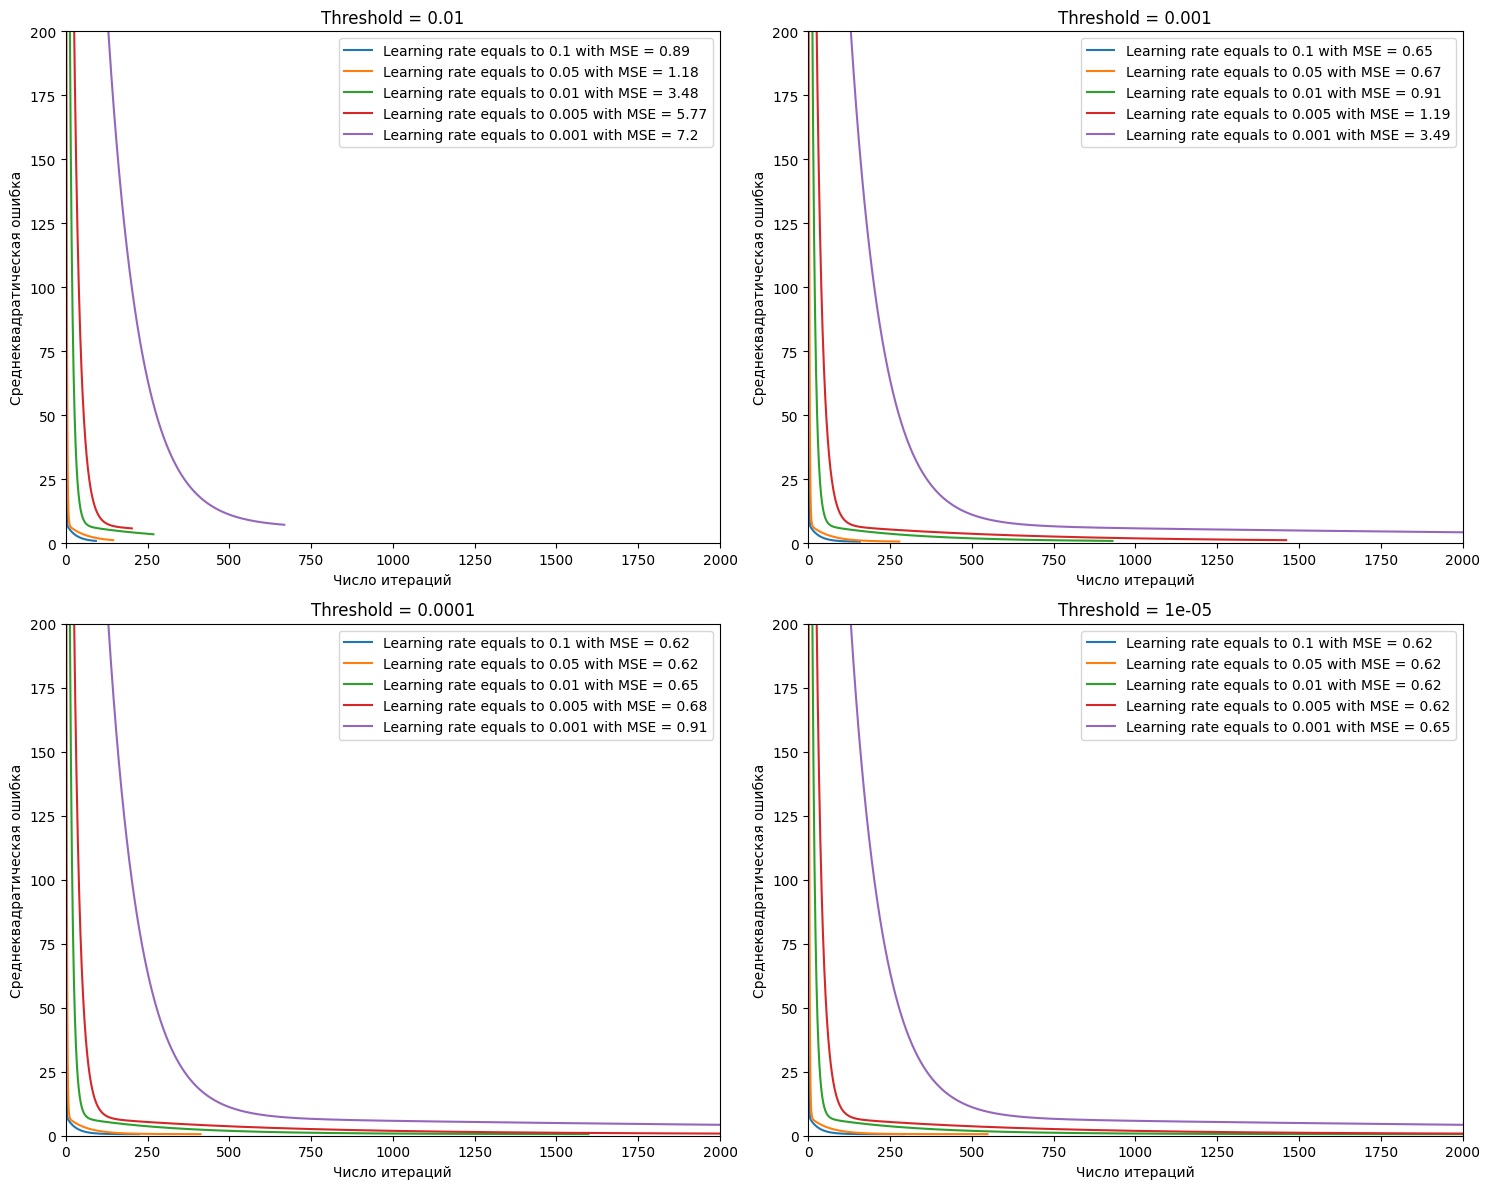

In [102]:
fig = plt.figure()
fig.set_size_inches(15, 12)

thresholds = [1e-2, 1e-3, 1e-4, 1e-5]
learning_rates = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    legend_list = []
    for lr in learning_rates:
        GD = GradientDescentMse(X, Y, threshold=thresholds[i-1], learning_rate=lr)
        GD.learn()
        plt.plot(GD.iteration_loss_dict.keys(), GD.iteration_loss_dict.values())
        plt.title(f'Threshold = {thresholds[i-1]}')
        plt.xlabel('Число итераций')
        plt.ylabel('Среднеквадратическая ошибка')
        plt.xlim(0, 2000)
        plt.ylim(0, 200)
        legend_list.append(f'Learning rate equals to {lr} with MSE = {round(GD.calculate_mse_loss(), 2)}')
    plt.legend(legend_list)
    
fig.tight_layout()